# Prison construction and Black male incarceration
### Scott Cunningham

This notebook reproduces the weights from the last chapter of the book "Causal Inference: The Mixtape" by Scott Cunningham that examined prison construction and black male incarceration in the state of Texas. The study data is contained in the file `../data/texas.csv` (more detailed information on this dataset can be found in the book mentioned).

In [1]:
import pandas as pd
from pysyncon import Dataprep, Synth

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [2]:
df = pd.read_csv("../data/texas.csv")

dataprep = Dataprep(
    foo=df,
    predictors=["income", "ur", "poverty"],
    predictors_op="mean",
    time_predictors_prior=range(1985, 1994),
    special_predictors=[
        ("bmprison", [1988], "mean"),
        ("bmprison", [1990], "mean"),
        ("bmprison", [1991], "mean"),
        ("bmprison", [1992], "mean"),
        ("alcohol", [1990], "mean"),
        ("aidscapita", [1990], "mean"),
        ("aidscapita", [1991], "mean"),
        ("black", [1990], "mean"),
        ("black", [1991], "mean"),
        ("black", [1992], "mean"),
        ("perc1519", [1990], "mean"),
    ],
    dependent="bmprison",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="Texas",
    controls_identifier=[
        "Alabama",
        "Alaska",
        "Arizona",
        "Arkansas",
        "California",
        "Colorado",
        "Connecticut",
        "Delaware",
        "District of Columbia",
        "Florida",
        "Georgia",
        "Hawaii",
        "Idaho",
        "Illinois",
        "Indiana",
        "Iowa",
        "Kansas",
        "Kentucky",
        "Louisiana",
        "Maine",
        "Maryland",
        "Massachusetts",
        "Michigan",
        "Minnesota",
        "Mississippi",
        "Missouri",
        "Montana",
        "Nebraska",
        "Nevada",
        "New Hampshire",
        "New Jersey",
        "New Mexico",
        "New York",
        "North Carolina",
        "North Dakota",
        "Ohio",
        "Oklahoma",
        "Oregon",
        "Pennsylvania",
        "Rhode Island",
        "South Carolina",
        "South Dakota",
        "Tennessee",
        "Utah",
        "Vermont",
        "Virginia",
        "Washington",
        "West Virginia",
        "Wisconsin",
        "Wyoming",
    ],
    time_optimize_ssr=range(1985, 1994),
)

print(dataprep)

Dataprep
Treated unit: Texas
Dependent variable: bmprison
Control units: Alabama, Alaska, Arizona, Arkansas, California, Colorado, Connecticut, Delaware, District of Columbia, Florida, Georgia, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New Hampshire, New Jersey, New Mexico, New York, North Carolina, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Carolina, South Dakota, Tennessee, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming
Time range in data: 1985.0 - 2000.0
Time range for loss minimization: range(1985, 1994)
Time range for predictors: range(1985, 1994)
Predictors: income, ur, poverty
Special predictors:
    `bmprison` over `[1988]` using `mean`
    `bmprison` over `[1990]` using `mean`
    `bmprison` over `[1991]` using `mean`
    `bmprison` over `[1992]` using `mean`
    `alcohol` over `[1990]` using `mea


We supply the `Dataprep` object to a `Synth` object. The optimisation scheme we use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [3]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="BFGS", optim_initial="ols")

synth.weights(threshold=0.01)

California    0.409
Florida       0.108
Illinois      0.361
Louisiana     0.122
Name: weights, dtype: float64

The synthetic control obtained from the optimisation is: $$\text{Synthetic Control} = 0.409 \times \text{California} + 0.108 \times \text{Florida} + 0.361 \times \text{Illinois} + 0.122 \times \text{Louisiana}.$$

The `path_plot` method shows the path of the treated unit and the synthetic control over time.

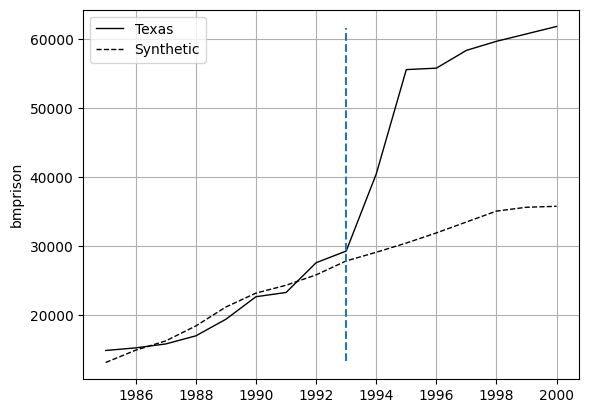

In [4]:
synth.path_plot(time_period=range(1985, 2001), treatment_time=1993)

The `gaps_plot` method shows the gaps (the difference between the treated unit and the synthetic control) over time.

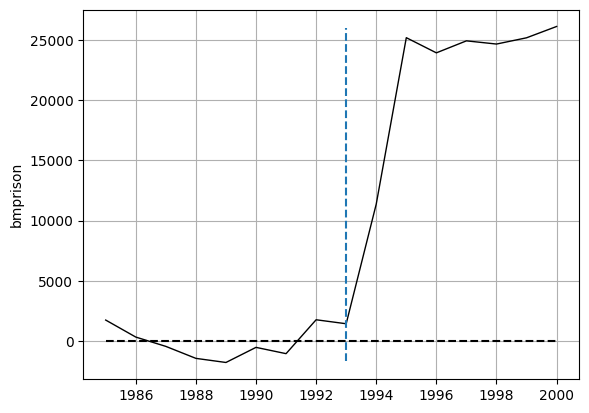

In [5]:
synth.gaps_plot(time_period=range(1985, 2001), treatment_time=1993)

Compute the average treatment effect on the treated unit (ATT) over the post-treatment time period, also returns a standard error (se).

In [6]:
synth.att(time_period=range(1993, 2001))

{'att': 20339.375838131393, 'se': 3190.4946788704715}

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [7]:
synth.summary()

,V,treated,synthetic,sample mean
income,0.000,16485.778,19003.932,17480.102
ur,0.000,7.399,7.314,6.167
poverty,0.000,17.222,15.169,13.492
special.1.bmprison,0.041,16956.000,18394.431,4872.160
special.2.bmprison,0.041,22634.000,23159.063,6098.230
special.3.bmprison,0.056,23249.000,24296.887,6560.480
special.4.bmprison,0.145,27568.000,25803.122,6971.660
special.5.alcohol,0.000,2.470,2.712,2.504
special.6.aidscapita,0.015,13.590,15.006,8.763
special.7.aidscapita,0.016,14.835,17.252,10.126
